In [1]:
import sys
sys.path.append('./src/')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


In [2]:
def plot_single_serie(uid_df, ax):
    """
    uid_df: pandas df
    panel with columns unique_id, ds, y, split
    y_hat_df: pandas df
    panel with columns unique_id, ds, y_hat
    """
    # parse uid_df
    uid_df.reset_index(inplace=True)
    
    # plot last 60 observations
    sns.lineplot(x='ds', y='y', 
                 hue='split', data=uid_df[-60:], ax=ax) #, palette=['#FA6F94','#51DBE6']
    
    #print("uid_df.dtypes \n", uid_df.dtypes)
    #assert 1<0
    
    sns.lineplot(x='ds', y='Naive',
             color='#51DBE6', data=uid_df[-60:], ax=ax, label='Naive')
    sns.lineplot(x='ds', y='SeasonalNaive',
             color='#FA6F94', data=uid_df[-60:], ax=ax, label='SeasonalNaive')
    sns.lineplot(x='ds', y='Naive2',
             color='green', data=uid_df[-60:], ax=ax, label='Naive2')
    sns.lineplot(x='ds', y='RandomWalkDrift',
             color='green', data=uid_df[-60:], ax=ax, label='RandomWalkDrift')
    sns.lineplot(x='ds', y='Croston',
             color='yellow', data=uid_df[-60:], ax=ax, label='Croston')
    sns.lineplot(x='ds', y='MovingAverage',
             color='black', data=uid_df[-60:], ax=ax, label='MovingAverage')
    sns.lineplot(x='ds', y='SeasonalMovingAverage',
             color='purple', data=uid_df[-60:], ax=ax, label='SeasonalMovingAverage')
    
    # rotate x axis
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y')
    ax.set_xlabel('Date Stamp')
    ax.set_ylabel('Value')
    
    # remove legend title
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])

def plot_grid_series(y, uids):
    assert len(uids)==8
    
    fig, axs = plt.subplots(2, 4, figsize=(20, 7))
    plt.subplots_adjust(wspace=0.35)
    plt.subplots_adjust(hspace=0.4)
    plt.xticks(rotation=45)

    for i, uid in enumerate(uids):
        # single plot parameters
        uid_df = y.loc[uid]
        #uid_df = y_df[y_df.unique_id==uid]
        row = int(np.round(i/8 + 0.001))
        col = i % 4
        
        plot_single_serie(uid_df, ax=axs[row, col])
    
    fig.tight_layout()
    plt.show()
    plot_file = "./results/grid_series.png"
    plt.savefig(plot_file, bbox_inches = "tight", dpi=300)
    plt.close()





 Fitting models
Naive
SeasonalNaive
Naive2
RandomWalkDrift
Croston
MovingAverage
SeasonalMovingAverage

 Evaluating models
mape
smape
mase
rmsse


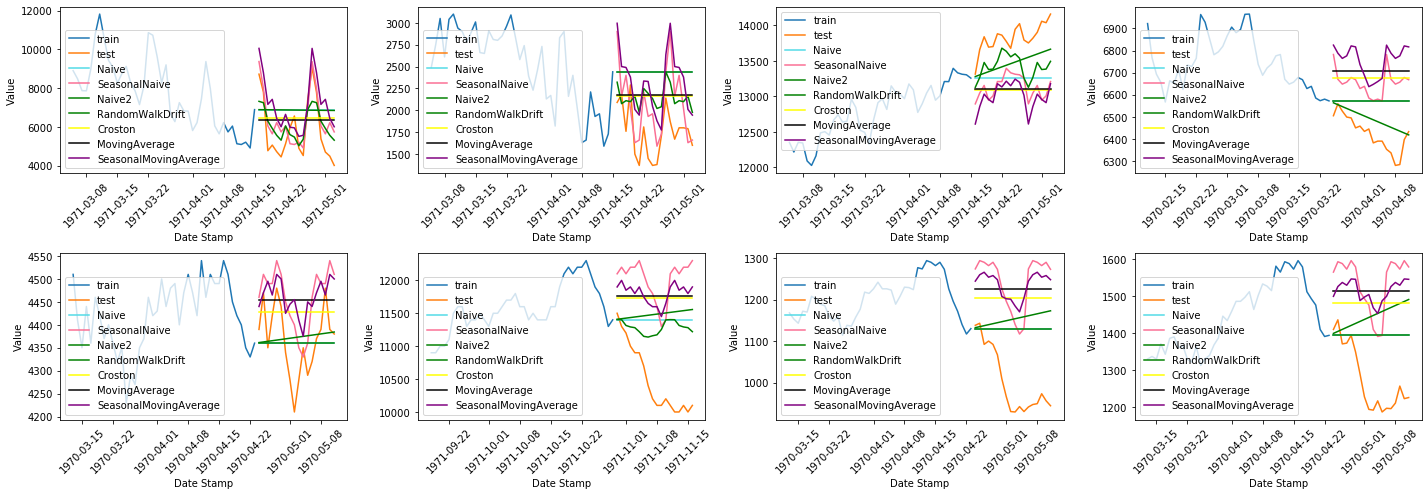

,mape,smape,mase,rmsse
Naive,14.587706,12.554884,154.674149,136.386826
SeasonalNaive,16.363638,14.468293,212.723064,190.695496
Naive2,11.431736,10.404474,132.266144,121.989494
RandomWalkDrift,15.068192,12.940476,150.544054,133.972818
Croston,14.547862,13.050489,188.319747,163.158629
MovingAverage,15.227935,13.655002,199.849112,172.896039
SeasonalMovingAverage,18.185127,15.546451,226.685040,200.534507


In [3]:
from src.benchmarks import *
from src.utils_data import M4_parser
from src.utils_evaluation import *

seas_dict = {'Hourly': {'seasonality': 24, 'input_size': 24,
                       'output_size': 48},
             'Daily': {'seasonality': 7, 'input_size': 7,
                       'output_size': 14},
             'Weekly': {'seasonality': 52, 'input_size': 52,
                        'output_size': 13},
             'Monthly': {'seasonality': 12, 'input_size': 12,
                         'output_size':18},
             'Quarterly': {'seasonality': 4, 'input_size': 4,
                           'output_size': 8},
             'Yearly': {'seasonality': 1, 'input_size': 4,
                        'output_size': 6}}

def ml_pipeline(dataset_name, num_obs, models_filter, metrics_filter):
    # Parse arguments
    h = seas_dict[dataset_name]['output_size']
    seasonality = seas_dict[dataset_name]['seasonality']

    models = {'Naive':  Naive(h=h),
              'SeasonalNaive': SeasonalNaive(h=h, seasonality=seasonality),
              'Naive2': Naive2(h=h, seasonality=seasonality),
              'RandomWalkDrift': RandomWalkDrift(h=h),
              'Croston': Croston(kind='classic'),
              'MovingAverage': MovingAverage(h=h, n_obs=20),
              'SeasonalMovingAverage': SeasonalMovingAverage(h=h, n_seasons=2,
                                                             seasonality=seasonality)}
    
    metrics = {'mse': mse, 'mape': mape, 'smape': smape, 
               'mase': mase, 'rmsse': rmsse}
    
    # Filtered models and metrics
    models = {model_name: models[model_name] for model_name in models_filter}
    metrics = {metric_name: metrics[metric_name] for metric_name in metrics_filter}
    
    # Read data
    X_train_df, y_train_df, X_test_df, y_test_df = M4_parser(dataset_name, num_obs)

    # Pre sort dataframes for efficiency
    X_train_df = X_train_df.set_index(['unique_id', 'ds']).sort_index()
    y_train_df = y_train_df.set_index(['unique_id', 'ds']).sort_index()
    X_test_df = X_test_df.set_index(['unique_id', 'ds']).sort_index()
    y_test_df = y_test_df.set_index(['unique_id', 'ds']).sort_index()
    
    # Fit and predict benchmark models
    preds = [y_test_df.y]
    print("\n Fitting models")
    for model_name, model in models.items():
        print(model_name)
        
        panel_model = PanelModel(model)
        panel_model.fit(X_train_df, y_train_df)
        mod_preds = panel_model.predict(X_test_df)
        
        mod_preds.name = model_name
        preds.append(mod_preds)
    
    # Merge y_df for visualization purpose
    y_hat_df = pd.concat(preds, axis=1)
    y_train_df['split'] = 'train'
    y_hat_df['split'] = 'test'
    y_df = y_train_df.append(y_hat_df, sort=False)
    
    # Evaluation Metrics
    evaluations = {}
    print("\n Evaluating models")
    for metric_name, metric in metrics.items():
        print(metric_name)
        for mod_preds in preds[1:]:
            mod_evaluation = evaluate_panel(y_test=y_test_df, y_hat=mod_preds,
                                            y_train=y_train_df, metric=metric,
                                            seasonality=seasonality)
            mod_evaluation.name = mod_preds.name

            if not (metric_name in evaluations.keys()):
                evaluations[metric_name] = [mod_evaluation]
            else:
                evaluations[metric_name].append(mod_evaluation)
    
    # Collapse Metrics
    for metric_name, metric in metrics.items():
        evaluations[metric_name] = pd.concat(evaluations[metric_name], axis=1)
        evaluations[metric_name] = evaluations[metric_name].mean(axis=0)
    
    evaluations = pd.DataFrame.from_dict(evaluations)
    return y_df, evaluations

# Grid Plot
dataset_name = 'Monthly'
models_filter = ['Naive', 'SeasonalNaive', 'Naive2',
                 'RandomWalkDrift', 'Croston', 'MovingAverage', 'SeasonalMovingAverage']
# models_filter = ['RandomWalkDrift', 'Croston', 'MovingAverage', 'SeasonalMovingAverage']
metrics_filter = ['mape', 'smape', 'mase', 'rmsse']

y_df, metrics = ml_pipeline(dataset_name=dataset_name, num_obs=8, 
                            models_filter=models_filter, metrics_filter=metrics_filter)

uids = ['M1', 'M2', 'M3', 'M4','M5', 'M6', 'M7', 'M8']
plot_grid_series(y_df, uids)
metrics